In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load Data

In [2]:
df = pd.read_json(
    "../data/arxiv-metadata-oai-snapshot.json",
    lines=True,
    orient='records',
    nrows=1000000  # from 2866787 rows
)

In [3]:
df.shape

(1000000, 14)

In [4]:
df.columns

Index(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'],
      dtype='object')

In [5]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


# Preprocessing

In [6]:
# Dropping columns that are not important
df = df.drop(columns=['submitter', 'report-no', 'license', 'authors_parsed'])

## Handling Missing & Duplicate Values

In [7]:
# Checking Missing Values
print("Null values in 'comments':", df['comments'].isnull().sum())
print("Null values in 'journal-ref':", df['journal-ref'].isnull().sum())
print("Null values in 'doi':", df['doi'].isnull().sum())

print("\nNull values in critical columns before dropping:")
print(df[['abstract', 'title', 'authors']].isnull().sum())

Null values in 'comments': 218584
Null values in 'journal-ref': 608826
Null values in 'doi': 449245

Null values in critical columns before dropping:
abstract    0
title       0
authors     0
dtype: int64


In [8]:
# Replacing Missing Values with ""
df['comments'] = df['comments'].fillna('')
df['journal-ref'] = df['journal-ref'].fillna('')
df['doi'] = df['doi'].fillna('')

In [9]:
# Check for duplicate IDs
duplicate_id_count = df.duplicated(subset=['id']).sum()
print(f"Number of duplicate IDs: {duplicate_id_count}")

# Check for duplicate titles
duplicate_title_count = df.duplicated(subset=['title']).sum()
print(f"Number of duplicate titles: {duplicate_title_count}")

Number of duplicate IDs: 0
Number of duplicate titles: 1291


In [10]:
# Removing Duplicates
df = df.drop_duplicates(subset=['title'], keep='first')

In [11]:
df.shape

(998709, 10)

In [12]:
df.head()

,id,authors,title,comments,journal-ref,doi,categories,abstract,versions,update_date
0,704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,hep-ph,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26
1,704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,,,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13
2,704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",,,physics.gen-ph,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13
3,704.0004,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,,,math.CO,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23
4,704.0005,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,,"Illinois J. Math. 52 (2008) no.2, 681-689",,math.CA math.FA,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15


## Normalizing Columns

In [13]:
def clean_text(text):
    text = text.lower() 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip() # Remove leading/trailing whitespace

    # Remove stopwords
    words = text.split() 
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    
    return ' '.join(words)

In [14]:
df['abstract_clean'] = df['abstract'].apply(clean_text)
df['title_clean'] = df['title'].apply(clean_text)

In [15]:
# Processing authors information
df['authors'] = df['authors'].str.replace(r'\\', '', regex=True).str.replace('\n', ' ').str.strip()

In [16]:
# Processing categories
df['primary_category'] = df['categories'].apply(lambda x: x.split()[0] if isinstance(x, str) and len(x) > 0 else 'unknown')

In [17]:
# Processing Dates & Versions
df['update_date'] = pd.to_datetime(df['update_date'], errors='coerce')

df['num_versions'] = df['versions'].apply(len)
df['first_version_date'] = df['versions'].apply(lambda x: x[0]['created'] if len(x) else None)

df.drop(columns=['versions'], inplace=True)

In [18]:
df.head()

,id,authors,title,comments,journal-ref,doi,categories,abstract,update_date,abstract_clean,title_clean,primary_category,num_versions,first_version_date
0,704.0001,"C. Bal'azs, E. L. Berger, P. M. Nadolsky, C.-P...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,hep-ph,A fully differential calculation in perturba...,2008-11-26,fully differential calculation perturbative qu...,calculation prompt diphoton production cross s...,hep-ph,2,"Mon, 2 Apr 2007 19:18:42 GMT"
1,704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,,,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,new algorithm kellpebble game colors use obtai...,sparsitycertifying graph decompositions,math.CO,2,"Sat, 31 Mar 2007 02:26:18 GMT"
2,704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",,,physics.gen-ph,The evolution of Earth-Moon system is descri...,2008-01-13,evolution earthmoon described dark matter fiel...,evolution earthmoon based dark matter field fl...,physics.gen-ph,3,"Sun, 1 Apr 2007 20:46:54 GMT"
3,704.0004,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,,,math.CO,We show that a determinant of Stirling cycle...,2007-05-23,determinant stirling cycle numbers counts unla...,determinant stirling cycle numbers counts unla...,math.CO,1,"Sat, 31 Mar 2007 03:16:14 GMT"
4,704.0005,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,,"Illinois J. Math. 52 (2008) no.2, 681-689",,math.CA math.FA,In this paper we show how to compute the $\L...,2013-10-15,paper compute lambdaalpha norm alphage 0 using...,dyadic lambdaalpha lambdaalpha,math.CA,1,"Mon, 2 Apr 2007 18:09:58 GMT"


In [19]:
df.columns

Index(['id', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'categories', 'abstract', 'update_date', 'abstract_clean',
       'title_clean', 'primary_category', 'num_versions',
       'first_version_date'],
      dtype='object')

## Saving in pickle file

In [ ]:
df.to_pickle('../data/processed_arxiv_data.pkl')

Preprocessing completed and data saved as 'processed_arxiv_data.pkl'


# EDA

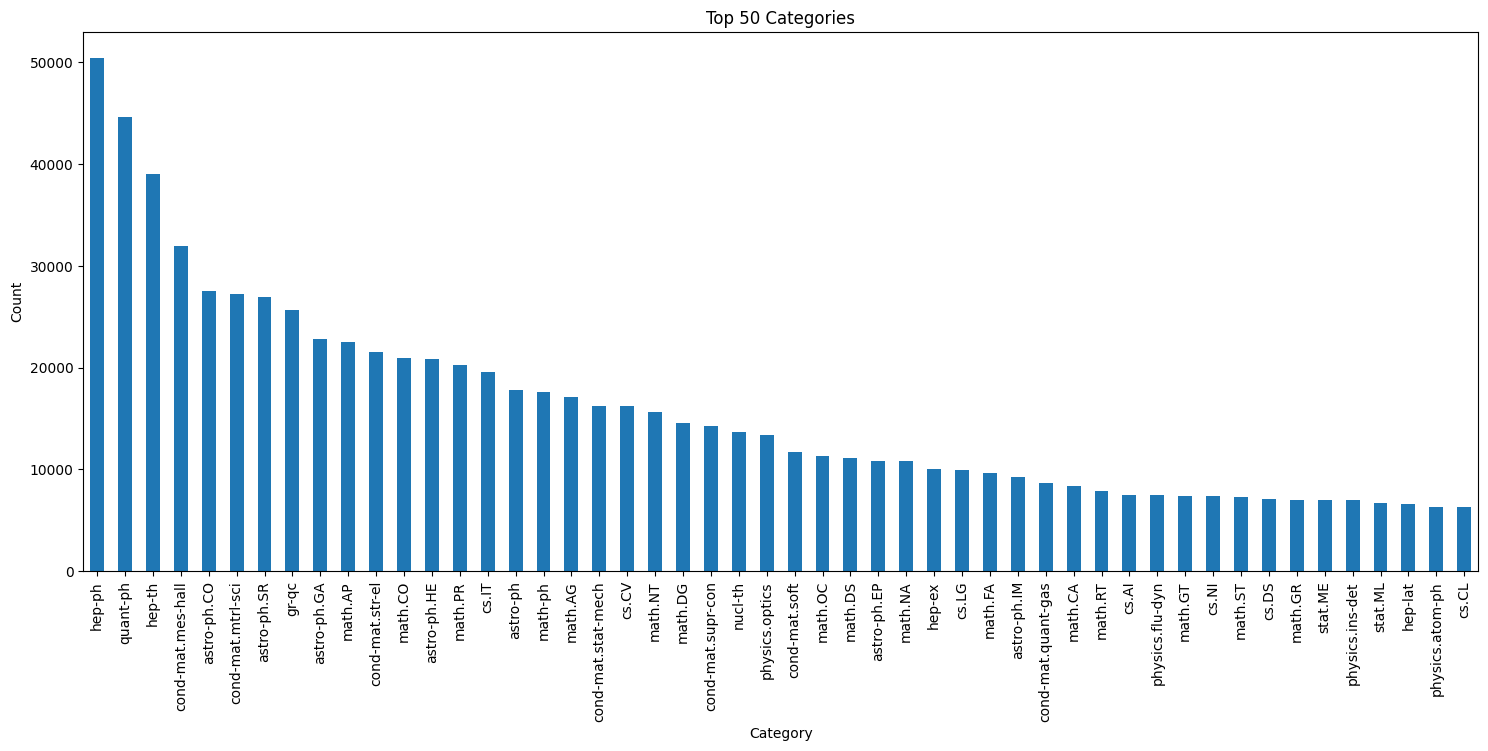

In [ ]:
# Top 50 Most Common Categories
plt.figure(figsize=(18, 7))

pd.Series(df.primary_category).value_counts().head(50).plot(kind='bar')
plt.title("Top 50 Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

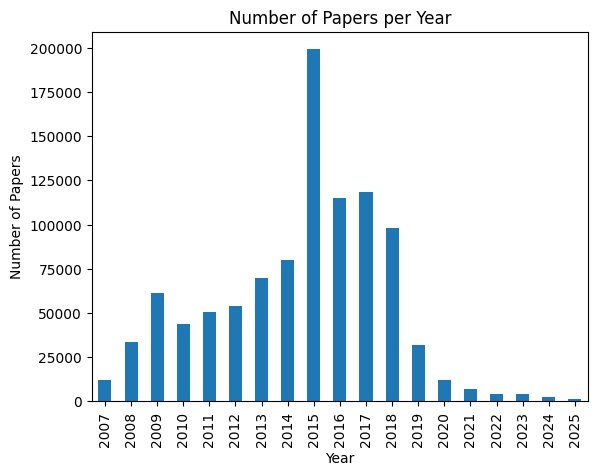

In [ ]:
# Distribution of Papers per Year
df['year'] = df['update_date'].dt.year
df['year'].value_counts().sort_index().plot(kind='bar')

plt.title("Number of Papers per Year")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.show()

## Author Search

In [23]:
def search_authors(author_query, df, top_k=10):
    author_query = author_query.strip().lower() # Clean and preprocess input if necessary
    
    mask = df['authors'].str.lower().str.contains(author_query) # Filter DataFrame rows containing the author name (case-insensitive)
    results = df[mask].copy()
    results['similarity_score'] = 1.0  # All matches marked as high similarity
    
    return results.head(top_k)

In [24]:
search_authors("Louis", df, top_k=5)

,id,authors,title,comments,journal-ref,doi,categories,abstract,update_date,abstract_clean,title_clean,primary_category,num_versions,first_version_date,year,similarity_score
1,704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,,,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,new algorithm kellpebble game colors use obtai...,sparsitycertifying graph decompositions,math.CO,2,"Sat, 31 Mar 2007 02:26:18 GMT",2008,1.0
737,704.0738,Patrick Ilg and Jean-Louis Barrat,Driven activation versus thermal activation,"5 pages, 3 figures",EPL 79 (2007) 26001,10.1209/0295-5075/79/26001,cond-mat.stat-mech cond-mat.dis-nn,Activated dynamics in a glassy system underg...,2010-11-12,activated dynamics glassy undergoing steady sh...,driven activation versus thermal activation,cond-mat.stat-mech,1,"Thu, 5 Apr 2007 15:06:03 GMT",2010,1.0
877,704.0878,"Am'elie Juhin (IMPMC), Georges Calas (IMPMC), ...",Structural relaxation around substitutional Cr...,"7 pages, 4 figures",,10.1103/PhysRevB.76.054105,cond-mat.mtrl-sci,The structural environment of substitutional...,2016-08-14,structural environment substitutional cr3 ion ...,structural relaxation substitutional cr3 mgal2o4,cond-mat.mtrl-sci,1,"Fri, 6 Apr 2007 11:46:08 GMT",2016,1.0
997,704.0998,Louise Nyssen (I3M),"Test vectors for trilinear forms, when two rep...",,,,math.NT,Let F be a finite extension of Qp and G be G...,2007-05-23,let f finite extension qp g gl2f v tensor prod...,test vectors trilinear forms representations u...,math.NT,1,"Sat, 7 Apr 2007 19:42:53 GMT",2007,1.0
1245,704.1246,"Louis H. Kauffman, Jo~ao Faria Martins",Invariants of Welded Virtual Knots Via Crossed...,New results. A perfected version will appear i...,"Compositio Mathematica, 144(4), 1046-1080 (2008)",10.1112/S0010437X07003429,math.GT hep-th math.QA,We define an invariant of welded virtual kno...,2017-05-23,define invariant welded virtual knots finite c...,invariants welded virtual knots crossed module...,math.GT,2,"Tue, 10 Apr 2007 15:32:19 GMT",2017,1.0
